In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.optimize import curve_fit
plt.style.use("seaborn-v0_8-darkgrid")

In [46]:
# Load OGLE Cepheid catalog (LMC)
data_path = Path("asu.tsv")
df = pd.read_csv(data_path, sep="\t", comment="#")

# Convert selected columns to numeric
num_cols = ["Per", "Vmag", "Imag", "E(B-V)"]
for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Drop rows with missing period or V magnitude
clean = df[["Per", "Vmag"]].dropna()

In [47]:
display(clean.describe())

,Per,Vmag
count,204.000000,204.000000
mean,4.478774,15.850598
std,4.841457,0.827237
min,0.403540,9.999000
25%,2.354130,15.512750
50%,3.375205,15.856000
75%,4.896888,16.214750
max,56.498190,18.870000


In [48]:
# Period–Luminosity model: V = a * log10(P) + b
def pl_model(logP, a, b):
    return a * logP + b

logP = np.log10(clean["Per"].values)
V    = clean["Vmag"].values

popt, pcov = curve_fit(pl_model, logP, V)
a, b = popt
a_err, b_err = np.sqrt(np.diag(pcov))
print(f"a = {a:.3f} ± {a_err:.3f}")
print(f"b = {b:.3f} ± {b_err:.3f}")

a = -1.816 ± 0.154
b = 16.834 ± 0.095


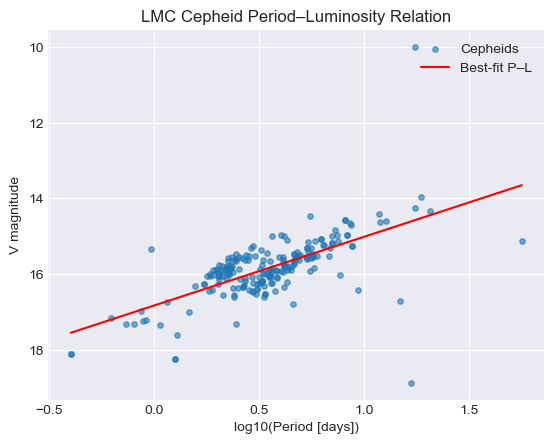

In [49]:
plt.figure()
plt.scatter(logP, V, s=15, alpha=0.6, label="Cepheids")

x = np.linspace(logP.min(), logP.max(), 200)
plt.plot(x, pl_model(x, a, b), color="red", label="Best-fit P–L")

plt.gca().invert_yaxis()
plt.xlabel("log10(Period [days])")
plt.ylabel("V magnitude")
plt.legend()
plt.title("LMC Cepheid Period–Luminosity Relation")
plt.show()

Estimated RMS scatter of residuals: 0.638 mag
Reduced chi^2 ≈ 1.00


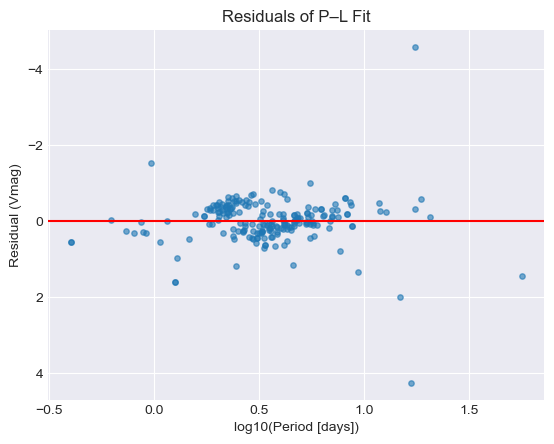

In [57]:
# --- Reduced chi^2 using the actual scatter of the data ---

# residuals from your fit (already defined above)
# resid = V - pl_model(logP, a, b)

# 1. Estimate the typical uncertainty from the data (RMS of residuals)
sigma_est = np.std(resid, ddof=2)   # ddof=2 because we fit 2 parameters (a, b)
print(f"Estimated RMS scatter of residuals: {sigma_est:.3f} mag")

# 2. Compute chi^2 and reduced chi^2
chi2 = np.sum((resid / sigma_est)**2)
dof = len(resid) - 2                # N - number_of_parameters
chi2_red = chi2 / dof
print(f"Reduced chi^2 ≈ {chi2_red:.2f}")

# 3. Residual plot (same as before)
plt.figure()
plt.scatter(logP, resid, s=15, alpha=0.6)
plt.axhline(0, color="red")
plt.xlabel("log10(Period [days])")
plt.ylabel("Residual (Vmag)")
plt.title("Residuals of P–L Fit")
plt.gca().invert_yaxis()
plt.show()